In [1]:
#Usual suspects
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Optional
import sys
sys.path.insert(1,'../muograph/')

# Function for plotting 3D points
def plot_3Dpoints(p:np.ndarray, vector:np.ndarray=None, point:np.ndarray=None, gap:float=100)->None:
    
    """
    Plots 3d points on 3 different views: XY, XZ, YZ.
    
    INPUT:
    - p:np.ndarray, the array containing the points coordinnates, with shape (Npoints,3)
    
    - vector:np.ndarray, the array containing the vector of a fitted line, with shape (3)
    
    - point:np.ndarray, the array containing a point of a fitted line, with shape (3)
    
    - gap:float, number used to set the plot lim. Must be of the order of magnitude of the point coordinnates. 
    
    OUTPUT:
    - None
    """
    
    fig,axs = plt.subplots(ncols=3)

    #XY view
    axs[0].scatter(p[:,0],p[:,1])
    axs[0].set_xlim((min(p[:,0])-gap,max(p[:,0])+gap))
    axs[0].set_ylim((min(p[:,1])-gap,max(p[:,1])+gap))

    #XZ view
    axs[1].scatter(p[:,0],p[:,2])
    axs[1].set_xlim((min(p[:,0])-gap,max(p[:,0])+gap))
    axs[1].set_ylim((min(p[:,2])-gap,max(p[:,2])+gap))

    #YZ view
    axs[2].scatter(p[:,1],p[:,2])
    axs[2].set_xlim((min(p[:,1])-gap,max(p[:,1])+gap))
    axs[2].set_ylim((min(p[:,2])-gap,max(p[:,2])+gap))

    #Compute fitted line coordinnates
    if((vector is not None)&(point is not None)):
        t = np.linspace(-1000,1000,100)
        fitted_line = np.zeros((3,100))
        for dim in [0,1,2]:
            #eq 1
            fitted_line[dim] = point[dim] + vector[dim]*t
            
        #plot fitted line
        axs[0].plot(fitted_line[0],fitted_line[1],color='red',label="fitted track")
        axs[1].plot(fitted_line[0],fitted_line[2],color='red',label="fitted track")
        axs[2].plot(fitted_line[1],fitted_line[2],color='red',label="fitted track")
        
        #plot point from fitted line
        axs[0].scatter(point[0],point[1],color='green')
        axs[1].scatter(point[0],point[2],color='green')
        axs[2].scatter(point[1],point[2],color='green')
        
    for ax in axs:
        #Show grid
        ax.grid("ON")
        #Same x and y scale
        ax.set_aspect("equal")
        # Show legend
        if((vector is not None)&(point is not None)):
            ax.legend()

    #axis legend
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Z")
    
    axs[2].set_xlabel("Y")
    axs[2].set_ylabel("Z")
    
    plt.tight_layout()
    plt.show()

# <center>  Tracking tutorial

**Tracking** in muon scattering tomography is **straightforward**, since muon tracks are straight tracks.

The **linear least squares fitting** technique is the simplest and most commonly applied form of linear regression and provides a solution to the problem of finding the best fitting straight line through a set of points. (https://mathworld.wolfram.com/LeastSquaresFitting.html).

**Mathematical expression**:

Given a set of points $X = \left\{X_0, ..., X_N\right\}$ where $X_i = \left\{x_i,y_i,z_i\right\}$, on has to find the best fitting straight line $L(t) = At + B$ where $A = \left\{ a_x,a_y,a_z\right\}$ and $B = \left\{ b_x,b_y,b_z\right\}$.

$$L_{x,y,z}(t) = a_{x,y,z} \times t +  b_{x,y,z}\:\:\:\:\:(1)$$


**Example**

In order to make things easier, one chooses to rely on the scikit-spatial library. The example below shows how to use the `best_fit` method of the `skspatial` `Line` class:

1- **Load hits** from a csv file

In [2]:
# Import get_hits_from_csv from utils.py
from utils.utils import get_hits_from_csv
# Get hits
hits = get_hits_from_csv('../data/DataCu.csv')

# Choose a random event
event = np.random.randint(hits.shape[-1])

# Choose a random plane
plane = np.random.randint(hits.shape[1])


print(r'Hit on plane {} for event {} has x,y,z = {},{},{} mm'.format(plane,event,hits[0,plane,event],hits[1,plane,event],hits[2,plane,event]))

Hit on plane 2 for event 42557 has x,y,z = 105.642,-133.028,-535.6 mm


In [3]:
# 1
points = np.transpose(hits[:,:,event],)
print("The first point (a.k.a points[0]) has x,y,z position {},{},{}".format(points[0,0],
                                                                             points[0,1],
                                                                             points[0,2]))

The first point (a.k.a points[0]) has x,y,z position 272.468,-95.612,-55.6


 2- For the sake of realism, let's add some gaussian **noise** to the $x$ and $y$ hit positions.


In [5]:
mean,std = 0,50
points[:-1] += np.random.normal(loc=mean, scale=std, size=points[:-1].shape)

 3- Create an **instance** of the `Points` class with our points: 


In [6]:
from skspatial.objects import Points
points = Points(points)

 4- **Fit** the points using the `best_fit` method of the `skspatial` `Line` class:

In [7]:
from skspatial.objects import Line
line_fit = Line.best_fit(points)

 5- Get the direction **vector** of the fitted line (A in eq. (1)) and the coordinnates of a **point** on the fitted line (B in eq. (1))

In [8]:
vector,point = line_fit.vector.to_array(), line_fit.point.to_array()

6- **Plot** the points and the fitted tracks using our homemade function

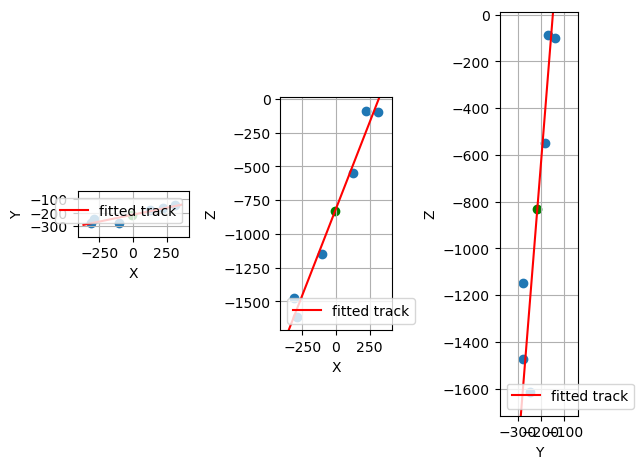

In [9]:
plot_3Dpoints(p=points,
              vector=vector,
              point=point)

## <center> **Section 1**: Tracking incoming and outgoing muons

    
### The basics
    
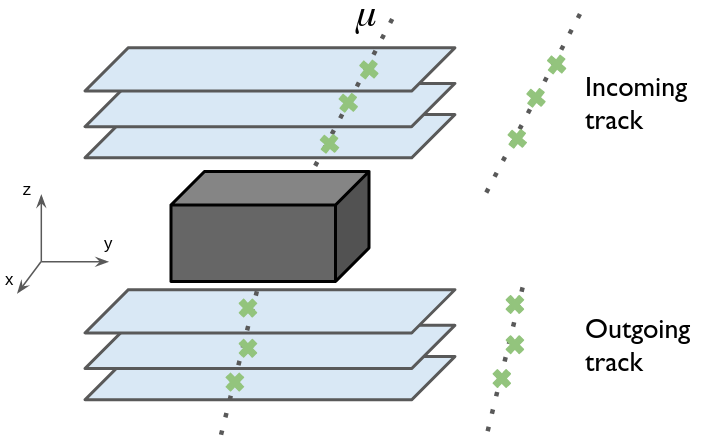

Now that we know how to fit a set of points, we can proceed to the **tracking** of **both** the **incoming** and **outgoing muon track**.

### <CENTER> **Exercice**


**Write a function** called `compute_vectors_points_from_hits()` that takes as **input**:
 
 - `hits:np.ndarray`, the hits of all detection planes with (3,n_plane,n_event)
 
and **returns**:

 - `points:np.ndarray`, the coordinnates of a **point** on the fitted lines, with shape (2,n_plane/2,n_event)
 - `vectors:np.ndarray`, the direction **vector** of the fitted lines, with shape (2,n_plane/2,n_event)


**Incoming** tracks points and vector will be stored in `points[0,:,:]` and `vectors[0,:,:]`, while **outgoing** tracks points and vector will be stored in `points[1,:,:]` and `vectors[1,:,:]`.

**Remarks**: 

 - When developping your function, try run the code for a small number of events.
 - Feel free to use parts of the code used in the tutorial above!

In [10]:
def compute_vectors_points_from_hits(hits:np.ndarray) -> Tuple[Tuple[np.ndarray]]:

    '''
     INPUT:
     
     - `hits:np.ndarray`, the hits of the **upper/lower** detection planes. Must have shape (3,3,n_event)
     
     OUTPUT:
     
     - `points:np.ndarray`, the coordinnates of a **point** on the fitted lines, with shape (2,3,n_event)
     - `vectors:np.ndarray`, the direction **vector** of the fitted lines (A in eq. (1)), with shape (2,3,n_event)
    '''
    
    vectors,points = np.zeros((2,hits.shape[1],hits.shape[2])), np.zeros((2,hits.shape[1],hits.shape[2]))
    
    # WRITE YOUR FUNCTION HERE
    
    return vectors, points

In [11]:
# Develop, try your function here
hits_up, hits_down = hits[:,:3], hits[:,3:]

### <center> **Test 1**


Now that the `compute_vectors_points_from_hits()` function is created, we have to make sure that it outputs the correct vector and point values. Using `hits_test`, run the `compute_vectors_points_from_hits_test()` test.

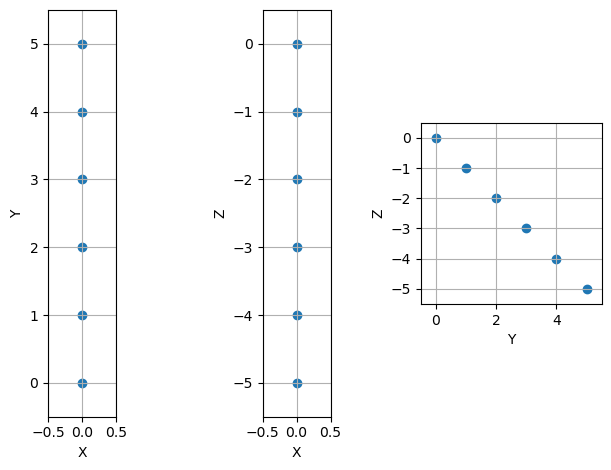

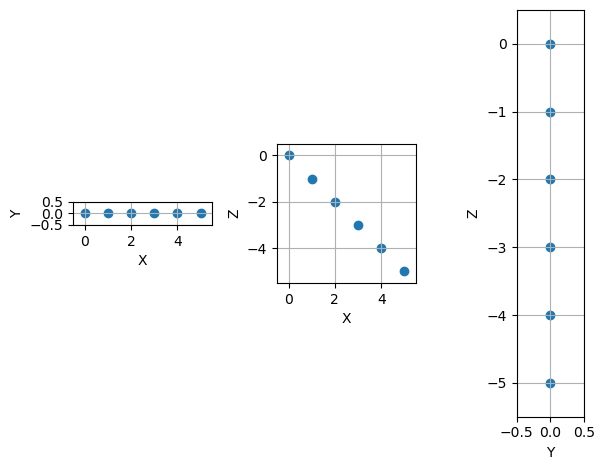

In [12]:
# Points to fit in order to pass the test
hits_test = np.array([[[ 0 ,  0 ],
                       [ 0 ,  1 ],
                       [ 0 ,  2 ],
                       [ 0 ,  3 ],
                       [ 0 ,  4 ],
                       [ 0 ,  5 ]],

                      [[ 0 ,   0],
                       [ 1 ,   0],
                       [ 2 ,   0],
                       [ 3 ,   0],
                       [ 4 ,   0],
                       [ 5 ,   0]],

                      [[ 0   ,  0   ],
                       [-1   , -1   ],
                       [-2   , -2   ],
                       [-3   , -3   ],
                       [-4   , -4   ],
                       [-5   , -5   ]]])

# Plot hits test
plot_3Dpoints(p=np.transpose(hits_test[:,:,0]),gap=.5)
plot_3Dpoints(p=np.transpose(hits_test[:,:,1]),gap=.5)

In [13]:
def compute_vectors_points_from_hits_test(hits_test:np.ndarray) -> None:
    
    output = compute_vectors_points_from_hits(hits_test)
    vectors, points = output[0], output[1]
    print("Incoming track fit for event 0")
    plot_3Dpoints(p = np.transpose(hits_test[:,:3,0]),
                  vector = vectors[0,:,0],
                  point = vectors[0,:,0],
                  gap = 1.)
    
    print("Outgoing track fit for event 0")
    plot_3Dpoints(p = np.transpose(hits_test[:,3:,0]),
                  vector = vectors[1,:,0],
                  point = vectors[1,:,0],
                  gap = 1.)
    
    # Variable type test
    assert type(output) == tuple
    assert type(vectors) == np.ndarray
    assert type(points) == np.ndarray

    # Variable value test
    assert np.sqrt((vectors[0,:,0]**2).sum()) == 1
    assert vectors[0,0,0] == 0
    print("TEST PASSED! :)")

Make sure you pass the test!

Incoming track fit for event 0


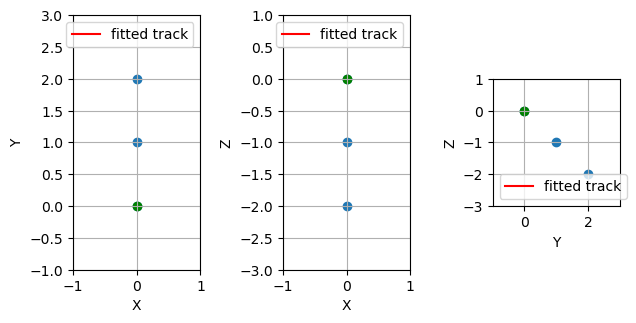

Outgoing track fit for event 0


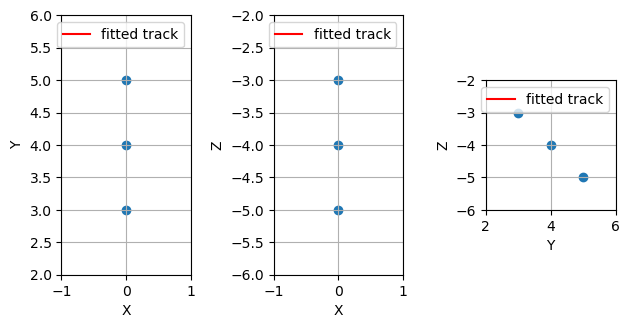

AssertionError: 

In [14]:
# Run test
compute_vectors_points_from_hits_test(hits_test)

You can now use our `compute_points_vectors_from_hits_test()` function to compute the fitted vectors and points:



In [14]:
vectors, points = compute_vectors_points_from_hits(hits[:,:,:10000])

## BONUS: Who has the most efficient code?


Using the `skspatial` library, `compute_point_vector_from_hits()` computation time is about 3.8s for 10k events (on Intel i5 CPU). Using the method of your choice, try to find a more efficent method!

In [15]:
import time
start = time.time()

# Put your function here
compute_vectors_points_from_hits(hits[:,:,:10000])

print("Computing time = {:.2f} s".format(time.time()-start))

Computing time = 3.64 s


# <center> **Exercice 2**: Computing zenith and azimuthal angles

    
### The basics

Now that we are able to **track** our **muons**, we can compute the **variables relevant** to our **image reconstruction analysis**.

<div>
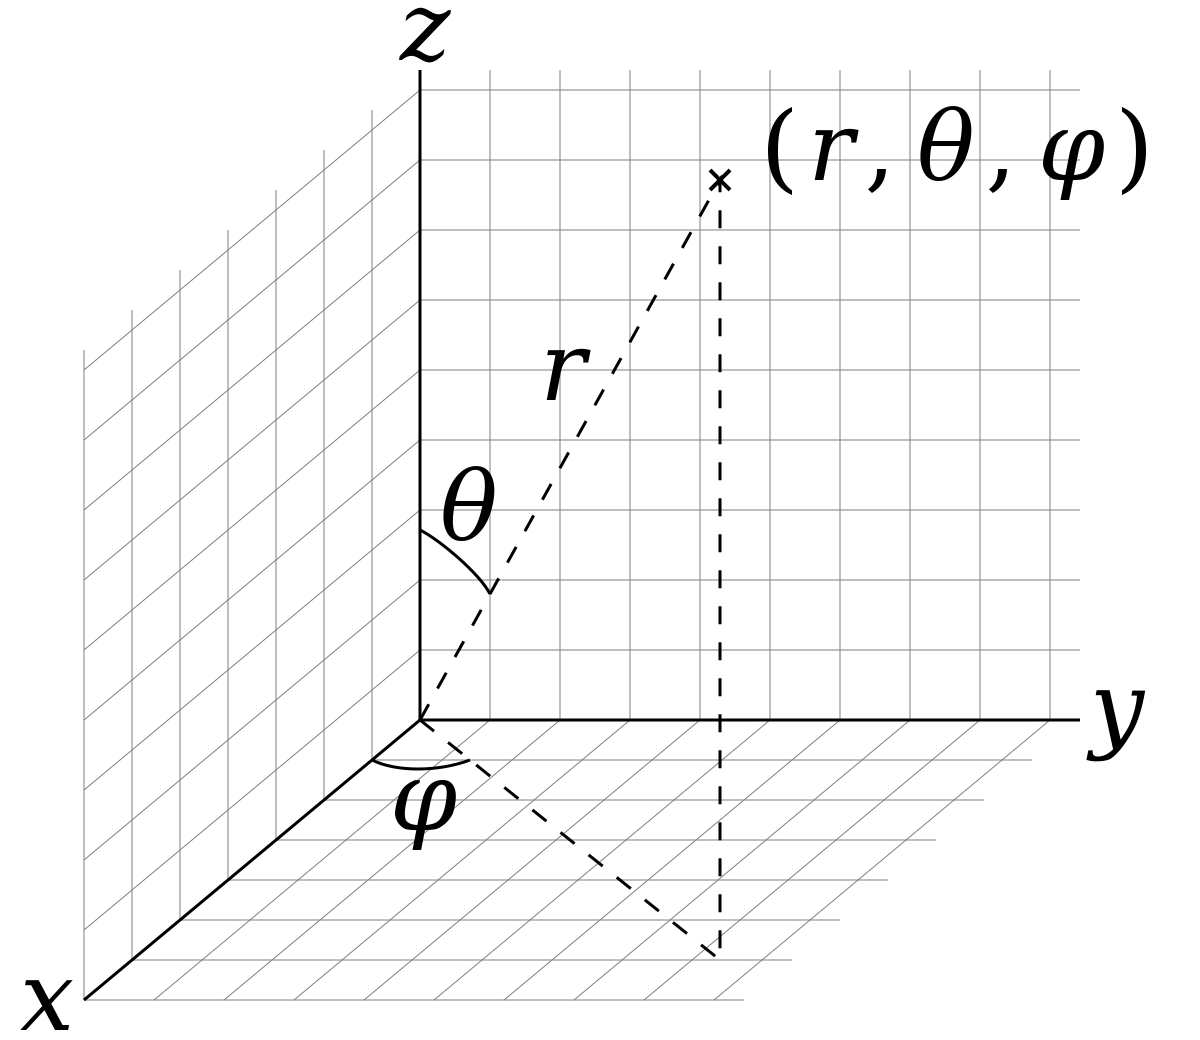
</div>


- $\theta$: the zenith angle, defined as the angle between our track and the vertical $z$ axis. Given a certain direction $v = \left\{ x, y, z \right\}$, it is computed as:

$$\theta =  \text{cos}^{-1}\left( \frac{z}{\sqrt{x^2 + y^2 + z^2}}\right)$$


- $\phi$: The azimuthal angle, defined as the angle between the projection of our track on the horizontal $xy$ plane and the $x$ axis.

$$ \phi = \text{sgn}(y) \: \text{cos}^{-1}\left( \frac{x}{\sqrt{x^2 + y^2}}\right)$$


### Exercice

**Create a function** called `compute_theta_phi()` that takes as **input**:

- `vector:np.ndarray`,  an array containing the tracks direction, with shape (3,n_event)

and **returns**:

- `theta:np.ndarray`, array containing the tracks zenith angle, with shape (n_event)

- `phi:np.ndarray`, array containing the tracks azymuthal angle, with shape (n_event)

**Remark**: 

 - Muon are propagating in the negative $z$ direction. You should take this into account when computing $\theta$!
 
 - When $\theta = 0$, $\phi$ is not defined. Instead, assign $\phi = 0$. You can use the `np.where()` function. (https://www.digitalocean.com/community/tutorials/python-numpy-where) 

In [1]:
def compute_theta_phi(vectors:np.ndarray) -> Tuple[np.ndarray]:
    
    '''
    INPUT:
     - vector:np.ndarray, array containing the tracks direction, with shape (3,n_event)
     
    OUTPUT:
    - theta:np.ndarray, array containing the tracks zenith angle, with shape (n_event)
    - phi:np.ndarray, array containing the tracks azymuthal angle, with shape (n_event)

    '''
    theta, phi = None, None
    
    # Fill here
    
    return theta, phi

NameError: name 'np' is not defined

In [17]:
#Develop your function here!

vectors_test = np.array([[0,1,-1,0,0,1,1,-1],[0,0,0,1,-1,0,1,-1],[-1,-1,-1,-1,-1,-1,-1,-1]])

## <center> **Test 2**


Now that the `compute_theta_phi()` function is created, we have to make sure that it outputs the correct $\theta$ and $\phi$ values. 

Using `vectors_test`, run the `compute_theta_phi_test()` test.

In [18]:
def compute_theta_phi_test(vectors_test:np.ndarray) -> None:
    vectors_test = np.array([[0,1,-1,0,0,1,1,-1],[0,0,0,1,-1,0,1,-1],[-1,-1,-1,-1,-1,-1,-1,-1]])
    
    output = compute_theta_phi(vectors=vectors_test)
    theta, phi = output[0], output[1]
    
    # Check variable type
    assert type(output) == tuple
    assert type(theta) == np.ndarray
    assert type(phi) == np.ndarray
    
    # Check values    
    assert (theta[1:6].round(3) == 0.785).sum() == 5, 'ERROR in theta computation!'
    assert (phi[:3].round(3) == 0.).sum() == 3, 'ERROR in phi computation!'
    assert np.sign(phi[4]) == -1.0, 'ERROR in phi sign!'
    assert ((np.sign(theta)==-1)==False).sum() == theta.shape, "ERROR in theta sign!"
    print("TEST PASSED! :)")


In [19]:
# Run the test here
compute_theta_phi_test(vectors_test)

TEST PASSED! :)


/tmp/ipykernel_7871/3100489620.py:31: RuntimeWarning: invalid value encountered in divide
  phi = np.sign(vectors[1])*np.arccos(vectors[0]/np.sqrt(vectors[0]**2+vectors[1]**2))


You cam now use our `compute_theta_phi()` function to compute $\theta$ and $\phi$:



In [20]:
theta_in, phi_in = compute_theta_phi(vectors[0])
theta_out, phi_out = compute_theta_phi(vectors[1])

# <center> **Exercice 3**: Computing scattering angles

We can now compute muons **scattering angle**. It is defined as the **angle between** the **incoming and outgoing** muon **direction**. Given $v_{in}$ and $v_{out}$ respectively incoming and outgoing direction vectors, the scattering angle $\Delta\theta$ can be computed as:
    
$$ \Delta\theta = \text{cos}^{-1}\left(\frac{\vec{v_{in}} \cdot \vec{v_{out}}}{|v_{in}||v_{out}|}\right)$$
    
In our case $\vec{v_{in}}$ is `vectors[0]` and $\vec{v_{out}}$ is `vectors[1]`.

### Exercice

**Create a function** called `compute_dtheta_from_vectors()` which takes as **input**:
    
 - `vectors_in:np.ndarray`, 3D vectors with shape (3,n_event)
 - `vectors_out:np.ndarray`, 3D vectors with shape (3,n_event)
    
and **returns**:

 - `dtheta:np.ndarray`, the scattering angle between vectors_in and vectors_out, with shape (n_event)
    
**Remarks**:

 - We might want to create a `dot_product` and `norm` function.
 - Because of floating precision, we might face cases where $\frac{\vec{v_{in}} \cdot \vec{v_{out}}}{|v_{in}||v_{out}|} = 1.0000000000002$ if the scattering angle is close to zero. Computing $\text{cos}^{-1}(1.0000000000002)$ will return a `nan` value (a.k.a Not A Number). In order to solve this problem, we might need to use the `np.round()` function (https://numpy.org/doc/1.13/reference/generated/numpy.round_.html).

In [15]:
def dot_prod(v1:np.ndarray, v2:np.ndarray) -> np.ndarray:
    
    '''
    Returns the dot product of 2 vectors or 2 array of vectors.

    INPUT:
     - v1:np.ndarray, a ND vector with shape (N,n_event) or (3)
     - v2:np.ndarray, a ND vector with shape (N,n_event) or (3)
     
     OUTPUT:
      - dot_prod:np.ndarray, the dot product of v1 and v2, with same shape as v1, v2
    '''
    # Fill here
    
    return 



def norm(v:np.ndarray) -> np.ndarray:
    
    '''
    Returns the norm of a ND vector or array of vectors.
    
    INPUT:
     - v:np.ndarray, a ND vector with shape (N,n_event) or (N)
     
     OUTPUT:
      - dot_prod:np.ndarray, the norm of v, with shape (n_event) or (1)
    '''
    # Fill here
    
    
    return 



def compute_dtheta_from_vectors(vectors_in:np.ndarray, vectors_out:np.ndarray) -> np.ndarray:
    
    '''
    Returns the angles between 2 collections of 3D vectors.
    
     INPUT:
     - vectors_in:np.ndarray, 3D vectors with shape (3,n_event) or (3)
     - vectors_out:np.ndarray, 3D vectors with shape (3,n_event) or (3)

     
     OUTPUT:
      - dtheta:np.ndarray, the scattering angle between vectors_in and vectors_out, with shape (n_event) or (1)
    '''
    # Fill here
    
    return 

You can use the cell below to test your function.

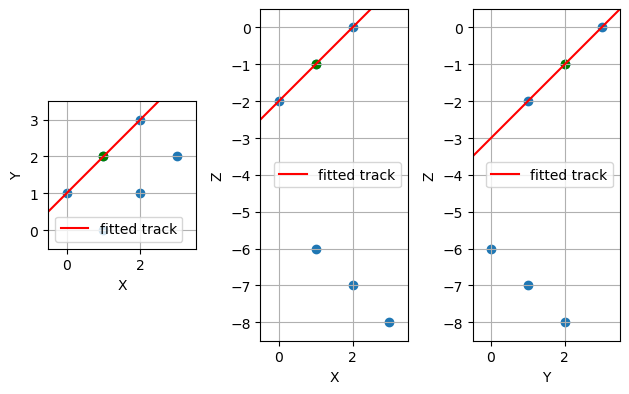

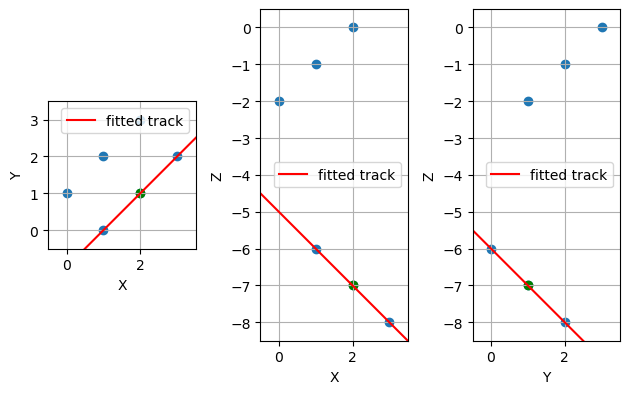

Scattering angle = 109.47 deg


In [23]:
# Develop your function here!

# Create FAKE hits
hits_scattering_test = np.array([[[ 0 , 2 ],
                                   [ 0 , 1],
                                   [ 0 , 0],
                                   [ 0 , 1],
                                   [ 0 , 2],
                                   [ 0 , 3]],

                                  [[ -3, 3],
                                   [ -2, 2],
                                   [ -1, 1],
                                   [ 0,  0],
                                   [-1,  1],
                                   [-2,  2]],

                                  [[ 0,  0],
                                   [-1, -1],
                                   [-2, -2],
                                   [-3, -6],
                                   [-4, -7],
                                   [-5, -8]]])

# Fit, and compute tracks direction
vectors, points = compute_vectors_points_from_hits(hits_scattering_test)

# Plot fake hits and fitted tracks
event = 1 #1
plot_3Dpoints(np.transpose(hits_scattering_test[:,:,event]),
              vector=vectors[0,:,event],
              point = points[0,:,event],
              gap=.5)

plot_3Dpoints(np.transpose(hits_scattering_test[:,:,event]),
              vector=vectors[1,:,event],
              point = points[1,:,event],
              gap=.5)

# Compute dtheta based on incoming and outgoing vectors
dtheta = compute_dtheta_from_vectors(vectors_in=vectors[0], vectors_out=vectors[1])

import math
print("Scattering angle = {:.2f} deg".format(dtheta[event]*180/math.pi))

## <center> Test 3
    
Now that the `compute_dtheta_from_vectors()` function is created, we have to make sure that it outputs the correct $d\theta$ values. 

Using `hits_scattering_test`, run the `compute_dtheta_from_vectors_test()` test and make sure it passes.

In [24]:
def compute_dtheta_from_vectors_test(test_hits:np.ndarray) -> None:
    
    vectors, points = compute_vectors_points_from_hits(test_hits)
    dtheta = compute_dtheta_from_vectors(vectors_in=vectors[0], vectors_out=vectors[1])

    # check varaible type and shape
    assert type(dtheta) == np.ndarray
    assert dtheta.shape == (2,)
    
    # check values
    assert dtheta[0].round(4) == np.round(math.pi/2,4), "ERROR in dtheta computation!"
    assert dtheta[1].round(4) == 1.9106, "ERROR in dtheta computation!"
        
    # Import get_hits_from_csv from utils.py
    from utils.utils import get_hits_from_csv
    hits = get_hits_from_csv('../data/DataCu.csv')
    
    vectors, points = compute_vectors_points_from_hits(hits[:,:,:10000])
    dtheta = compute_dtheta_from_vectors(vectors_in=vectors[0], vectors_out=vectors[1])
    assert np.isnan(dtheta).sum()==0, "NaN ERROR!"
    print("TEST PASSED! :)")
    
compute_dtheta_from_vectors_test(hits_scattering_test)

TEST PASSED! :)


You cam now use our `compute_theta_phi()` function to compute $\Delta\theta$

In [ ]:
dtheta = compute_dtheta_from_vectors(vectors_in=vectors[0], vectors_out=vectors[1])

# <center> **Exercice 4**: Creating a tracking class
    
    
### *Why using object-oriented programming*?

    
**Object-oriented programming** (OOP) is a computer programming model that **organizes software** design around **objects**, rather than functions and logic.
    
The organization of an object-oriented program also makes the method beneficial to **collaborative development**, where **projects** are **divided into groups**. Additional **benefits** of OOP include **code reusability** and **efficiency**.
    
Some references for beginers:
    
 - Short example https://www.youtube.com/watch?v=ZDa-Z5JzLYM 
 - Full course https://www.youtube.com/watch?v=Ej_02ICOIgs
    

### *What is the structure of object-oriented programming*?


### **Classes**
    
**Classes** are data types that act as the **blueprint** for individual objects, attributes and methods. In our case, we want to create a **tracking class** which will **encapsulate** all the **relevant attributes** as well as the **functions** required for their computation.

    
### **Objects**

**Objects** are instances of a class created with specifically defined data.

### **Methods**
    
**Methods** are functions that are **defined inside a class** that describe the behaviors of an object. Each method contained in class definitions starts with a reference to an instance object (`self`). In our case, we want to have the following methods:
    
 - `compute_points_vectors_from_hits()`
 - `compute_theta_phi()`
 - `compute_dtheta_from_vectors()`

### **Attributes**
 
**Attributes** are defined in the class template and represent the **state of an object**. Objects will have data stored in the attributes field. Class attributes belong to the class itself. In our case we want the following attributes:
    
 - $\theta_{in,out}$
 - $\phi_{in,out}$
 - $\Delta\theta$
 - number of event
 - number of detection planes

    
### Exercice

If you are confortable with OOP programming, you can include the functions you already created in the Tracking class below, and try to make it work.
    
If you are a beginner, don't worry you can skip this part an go directly to the next section.



In [ ]:
#Usual suspects
import numpy as np
from typing import Tuple, Optional
import math

class Tracking():
    
    '''
    Class for muon tracking in the context of an MST experiment.
    
    Assumptions:
    
     - Perfect detector alignment
    '''

    def __init__(self, hits:np.ndarray, E:Optional[np.ndarray]=None):
        
        self.hits = hits
        self.n_event = hits.shape[-1]
        self.n_plane = hits.shape[1]
        
        self.E = None
        
        # Tracking
        self.vectors, self.points = self.compute_points_vectors_from_hits()
        
        # Zenith and azymuthal angles
        self.theta_in, self.phi_in = self.compute_theta_phi(vectors=self.vectors[0])
        self.theta_out, self.phi_out = self.compute_theta_phi(vectors=self.vectors[1])
        
        # Scattering angles
        self.dtheta = self.compute_dtheta_from_vectors(vectors_in=self.vectors[0],
                                                       vectors_out=self.vectors[1])
      
        
    def compute_points_vectors_from_hits(self) -> Tuple[np.ndarray]:

        '''
         INPUT:

         - `hits:np.ndarray`, the hits of the **upper/lower** detection planes. Must have shape (3,n_plane,n_event)

         OUTPUT:

          - `point:np.ndarray`, the coordinnates of a **point** on the fitted line with shape (2,3,n_event)
          - `vector:np.ndarray`, the direction **vector** of the fitted line (A in eq. (1)) with shape (2,3,n_event)
        '''

        from skspatial.objects import Line, Points
        from fastprogress import progress_bar

        vectors = np.zeros((2,int(self.n_plane/2),self.n_event))
        points = np.zeros((2,int(self.n_plane/2),self.n_event))
        
        # Fill here
        
        return vectors, points

        
    def compute_theta_phi(self, vectors:np.ndarray) -> Tuple[np.ndarray]:
    
        '''
        INPUT:
         - vector:np.ndarray, array containing the tracks direction, with shape (3,n_event)

        OUTPUT:
        - theta:np.ndarray, array containing the tracks zenith angle, with shape (n_event)
        - phi:np.ndarray, array containing the tracks azymuthal angle, with shape (n_event)

        '''

        # Fill here

        return theta, phi
    
            
    def compute_dtheta_from_vectors(self, vectors_in:np.ndarray, vectors_out:np.ndarray) -> np.ndarray:
    
        '''
        Returns the angles between 2 collections of 3D vectors.

         INPUT:
         - vectors_in:np.ndarray, 3D vectors with shape (3,n_event) or (3)
         - vectors_out:np.ndarray, 3D vectors with shape (3,n_event) or (3)


         OUTPUT:
          - dtheta:np.ndarray, the scattering angle between vectors_in and vectors_in, with shape (n_event) or (1)
        '''
        # Fill here
        
        return dtheta
    
    
    def save(self, filename:str, directory:str="../data/tracking/") -> None:
        
        import pickle
        import os.path
        assert (os.path.isfile(directory+filename)==False), '{} file already exists!\
        \n Please choose another filename or delete existing file.'.format(filename)
        
        with open(directory+filename, 'wb') as f:
            pickle.dump(self,f)
            print("tracking class saved in {}".format(directory+filename))
            


    def plot_tracking_summary(self, figname:str=None, directory:str='../figures/tracking_summary/') -> None:

        import math
        import matplotlib.pyplot as plt
        fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(10,10))
        fig.suptitle("Tracking summary\n # events = {}".format(self.n_event))
        ax = ax.ravel()

        # Seetings
        alpha=.2

        # Plot theta 
        ax[0].hist(self.theta_in,bins=100,alpha=alpha,color='red',log=True)
        ax[0].set_xlabel(r"Incoming zenith angle $\theta_{in}$ [rad]")

        ax[2].hist(self.theta_out,bins=100,alpha=alpha,color='blue',log=True)
        ax[2].set_xlabel(r"Outgoing zenith angle $\theta_{out}$ [rad]")

        # Plot phi
        ax[1].hist(self.phi_in,bins=50,alpha=alpha,color='red')
        ax[1].set_xlabel(r"Incoming azymuthal angle $\phi{in}$ [rad]")

        ax[3].hist(self.phi_out,bins=50,alpha=alpha,color='blue')
        ax[3].set_xlabel(r"Outgoing azymuthal angle $\phi_{out}$ [rad]")

        # Plot scattering angle
        ax[4].hist(self.dtheta,bins=100,log=True,color='green',alpha=alpha,label='std = {:.2f}'.format(self.dtheta.std()))
        ax[4].set_xlabel(r"Scattering angle $d\theta$ [rad]")
        ax[4].legend()

        ax[5].hist(self.dtheta,
                bins=100,
                log=True,
                color='green',
                alpha=alpha,
                range=(0,math.pi/10))
        ax[5].set_xlabel(r"Scattering angle $d\theta$ [rad]")
        ax[5].axvline(x=self.dtheta.mean(),color='red',label='mean = {:.3f}'.format(self.dtheta.mean()))
        ax[5].legend()
        # Make it look nice
        plt.tight_layout()

        # Save figure in directory
        if(figname is not None):
            plt.savefig(directory+figname)
        plt.show()

## <center> Creating/using tracking file

Now that our class is created, let try to use it. First, create an empty txt file named `mytracking.py` in the `../muograph/tracking/` directory. Make sure you import the required libraries, put your tracking class in the file and save.


From now, we simply have to `import` our class from `mytracking.py` and we can use it wherever we want! If you were not able to make it work, use the `tracking.py` file instead.

In [ ]:
# Import the tracking class
import sys
sys.path.insert(1,'../muograph/')
from tracking.tracking import Tracking
# or 
# from tracking.mytracking import Tracking


In [ ]:
# Import get_hits_from_csv from utils.py
from utils.utils import get_hits_from_csv
# Get hits
hits = get_hits_from_csv('../data/DataCu.csv')

It takes only **1 line of code** to track our muons!

In [ ]:
# Instanciate the Tracking class for n_event events only
tracks = Tracking(hits=hits[:,:,:10000])

We can also easly access all tracking features! 

In [ ]:
# theta_in, theta_out
tracks.theta_in, tracks.theta_out

In [ ]:
# phi_in, phi_out
tracks.phi_in, tracks.phi_out

In [ ]:
# vectors, points
tracks.vectors, tracks.points

In [ ]:
# dtheta
tracks.dtheta

One can also use the `plot_tracking_summary()` method, which **plots** tracking class relevant **attributes**. If `figname` is provided, the figure will be saved in the `../figures/tracking_summary/` directory.

In [ ]:
# Plotting function
tracks.plot_tracking_summary(directory="../figures/tracking_summary/", figname="tracking_summary_tutorial")

The `save()` method allows to save the instance of the tracking class. By default, it will be saved in the `'../data/tracking/'`.

In [ ]:
# Save our tracks in a file
tracks.save(filename="tracks_tutorial")

To read the saved file, run:

In [ ]:
directory, filename = '../data/tracking/', 'tracks_tutorial'

with open(directory+filename, 'rb') as f:
    import pickle
    saved_tracks = pickle.load(f)